<a href="https://colab.research.google.com/github/olyavydrina/-/blob/main/%D0%92%D0%9A%D0%A0_%D0%B0%D0%BD%D0%B3%D0%BB%D0%B8%D0%B9%D1%81%D0%BA%D0%B8%D0%B9_%D1%8F%D0%B7%D1%8B%D0%BA_NLTK_%D0%BD%D0%B0_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Подключаем необходимые библиотеки

In [ ]:
%tensorflow_version 2.x
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, LSTM
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
!pip install pymorphy2[fast] 
import pymorphy2
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from sklearn.model_selection import train_test_split

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 KB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 48.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.1/371.1 KB 30.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for DAWG: filename=DAWG-0.8.0-cp38-cp38-linux_x86_64.whl size=1315977 sha256=bd8580edf865a41875d095f1b16fd15a8c051a991ffb0611fc80eb032ac08a2c
  Stored in directory: /root/.cache/pip/wheels/1c/e6/8f/313a7ccc57b29a7affb7205664277a1d5ebe73bf600a69a615
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=0a2d2780c0e1eb4f133457a7c5221df861cfc97f2791799c4184058f928a4d5d
  Stored in directory: /root/.cache/pip/wheels/56/ea/58/ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built DAWG docopt


In [ ]:
# Максимальное количество слов 
num_words = 10000
# Максимальная длина новости
max_news_len = 300
# Количество классов новостей
nb_classes = 2

In [ ]:
random_state = 42

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Загржаем и готовим набор данных

In [ ]:
#!wget https://github.com/olyavydrina/-/blob/main/train2.xlsx?dl=1 -O train2.xlsx

In [ ]:
#news = pd.read_excel('train2.xlsx')

In [ ]:
news = pd.read_excel('/content/train11.xlsx')
news.head()

,class,title,text,link,language
0,1,Freed Russian arms dealer Viktor Bout says he ...,Freed Russian arms dealer Viktor Bout said on ...,https://edition.cnn.com/2022/12/10/europe/vikt...,eng
1,1,Taiwan reports record incursion by Chinese bom...,China has sent a record 18 nuclear-capable H-6...,https://edition.cnn.com/2022/12/13/asia/taiwan...,eng
2,1,Soccer union ‘sickened’ by reports Iranian pla...,"The global soccer players’ union, FIFPRO, said...",https://edition.cnn.com/2022/12/13/middleeast/...,eng
3,1,At least seven dead as Peru protests disrupt f...,At least seven people have died in ongoing pro...,https://edition.cnn.com/2022/12/13/americas/pe...,eng
4,1,Indian and Chinese troops clash on disputed bo...,Indian and Chinese troops have clashed on thei...,https://edition.cnn.com/2022/12/13/asia/india-...,eng


In [ ]:
def preprocess(text, stop_words, punctuation_marks, morph):
    tokens = word_tokenize(text.lower())
    preprocessed_text = []
    for token in tokens:
        if token not in punctuation_marks:
            lemma = morph.parse(token)[0].normal_form
            if lemma not in stop_words:
                preprocessed_text.append(lemma)
    return preprocessed_text

In [ ]:
punctuation_marks = ['!', ',', '(', ')', ':', '-', '?', '.', '..', '...', '«', '»', ';', '–', '--']
stop_words = stopwords.words("english")
morph = pymorphy2.MorphAnalyzer()

In [ ]:
news['Preprocessed_texts'] = news.apply(lambda row: preprocess(row['text'], punctuation_marks, stop_words, morph), axis=1)

Считаем частоту слов во всех новостях

In [ ]:
words = Counter()

In [ ]:
for txt in news['Preprocessed_texts']:
    words.update(txt)

Создаем словарь, упорядоченный по частоте

В словаре будем использовать 2 специальных кода:

Код заполнитель: 0
Неизвестное слово: 1
Нумерация слов в словаре начинается с 2.

In [ ]:
# Словарь, отображающий слова в коды
word_to_index = dict()
# Словарь, отображающий коды в слова
index_to_word = dict()

Создаем словари

In [ ]:
for i, word in enumerate(words.most_common(num_words - 2)):
    word_to_index[word[0]] = i + 2
    index_to_word[i + 2] = word[0]

Функция для преобразования списка слов в список кодов

In [ ]:
def text_to_sequence(txt, word_to_index):
    seq = []
    for word in txt:
        index = word_to_index.get(word, 1) # 1 означает неизвестное слово
        # Неизвестные слова не добавляем в выходную последовательность
        if index != 1:
            seq.append(index)
    return seq


Преобразуем все тексты в последовательность кодов слов

In [ ]:
news['Sequences'] = news.apply(lambda row: text_to_sequence(row['Preprocessed_texts'], word_to_index), axis=1)

In [ ]:
news

,class,title,text,link,language,Preprocessed_texts,Sequences
0,1,Freed Russian arms dealer Viktor Bout says he ...,Freed Russian arms dealer Viktor Bout said on ...,https://edition.cnn.com/2022/12/10/europe/vikt...,eng,"[freed, russian, arms, dealer, viktor, bout, s...","[8643, 38, 815, 2261, 3287, 1351, 5, 173, 3, 6..."
1,1,Taiwan reports record incursion by Chinese bom...,China has sent a record 18 nuclear-capable H-6...,https://edition.cnn.com/2022/12/13/asia/taiwan...,eng,"[china, sent, record, 18, nuclear-capable, h-6...","[55, 470, 527, 1259, 4695, 6038, 3292, 708, 15..."
2,1,Soccer union ‘sickened’ by reports Iranian pla...,"The global soccer players’ union, FIFPRO, said...",https://edition.cnn.com/2022/12/13/middleeast/...,eng,"[global, soccer, players, ’, union, fifpro, sa...","[263, 602, 1024, 2, 150, 6054, 5, 3, 4704, 867..."
3,1,At least seven dead as Peru protests disrupt f...,At least seven people have died in ongoing pro...,https://edition.cnn.com/2022/12/13/americas/pe...,eng,"[least, seven, people, died, ongoing, protests...","[168, 604, 7, 342, 1357, 211, 212, 46, 19, 147..."
4,1,Indian and Chinese troops clash on disputed bo...,Indian and Chinese troops have clashed on thei...,https://edition.cnn.com/2022/12/13/asia/india-...,eng,"[indian, chinese, troops, clashed, disputed, h...","[1029, 270, 443, 6079, 3311, 8707, 188, 28, 24..."
...,...,...,...,...,...,...,...
184,0,Sir Keir Starmer rakes it in after 'selling gr...,Sir Keir Starmer sold seven acres of green-bel...,https://www.dailymail.co.uk/news/article-11550...,eng,"[sir, keir, starmer, sold, seven, acres, green...","[2254, 3275, 8274, 1301, 604, 614, 849, 68, 28..."
185,0,Rishi Sunak held 'migrants summit' with Theres...,Rishi Sunak held a ‘migrants summit’ with his ...,https://www.dailymail.co.uk/news/article-11550...,eng,"[rishi, sunak, held, ‘, migrants, summit, ’, p...","[2828, 2042, 306, 48, 3127, 574, 2, 2906, 4683..."
186,1,Putin is 'planning for a long war' and the Wes...,Putin is 'planning for a long war' and the Wes...,https://www.dailymail.co.uk/news/article-11546...,eng,"[putin, 'planning, long, war, ', west, must, c...","[90, 127, 53, 15, 265, 410, 273, 1156, 815, 14..."
187,1,Putin sends nuclear message to the West for a ...,Russia's nuclear sabre-rattling continued for ...,https://www.dailymail.co.uk/news/article-11545...,eng,"[russia, 's, nuclear, sabre-rattling, continue...","[25, 11, 400, 8638, 515, 794, 68, 694, 367, 73..."


## Выделяем данные для обучения и тестирования

In [ ]:
train, test = train_test_split(news, test_size=0.2)

In [ ]:
train

,class,title,text,link,language,Preprocessed_texts,Sequences
20,0,"What to know about Lensa, the AI portrait app ...","Zoe Sottile, CNN\nIf you've logged on to any s...",https://edition.cnn.com/style/article/lensa-ai...,eng,"[zoe, sottile, cnn, 've, logged, social, media...","[9308, 9309, 167, 2141, 6397, 227, 74, 419, 49..."
80,0,Your phone is terrible at phone calls. Here’s ...,If you want to scream because your phone calls...,https://www.washingtonpost.com/technology/2022...,eng,"[want, scream, phone, calls, sound, like, garb...","[78, 7665, 323, 325, 720, 20, 2, 376, 639, 797..."
8,1,South African President Ramaphosa will not be ...,South African President Ramaphosa survived a m...,https://edition.cnn.com/2022/12/13/africa/sout...,eng,"[south, african, president, ramaphosa, survive...","[110, 220, 19, 927, 2307, 257, 346, 1907, 6153..."
93,1,Canada: son of murdered billionaire couple tri...,The son of a billionaire couple murdered five ...,https://www.theguardian.com/world/2022/dec/12/...,eng,"[son, billionaire, couple, murdered, five, yea...","[1236, 3135, 928, 4580, 297, 17, 388, 753, 449..."
119,0,New Zealand passes world-first tobacco law to ...,New Zealand has introduced a steadily rising s...,https://www.theguardian.com/world/2022/dec/13/...,eng,"[new, zealand, introduced, steadily, rising, s...","[13, 3218, 2107, 648, 2014, 629, 356, 1438, 93..."
...,...,...,...,...,...,...,...
83,0,Emma Tucker to replace Matt Murray as editor o...,The Wall Street Journal on Monday named Emma T...,https://www.washingtonpost.com/media/2022/12/1...,eng,"[wall, street, journal, monday, named, emma, t...","[799, 623, 1189, 37, 1291, 5707, 2800, 6, 787,..."
1,1,Taiwan reports record incursion by Chinese bom...,China has sent a record 18 nuclear-capable H-6...,https://edition.cnn.com/2022/12/13/asia/taiwan...,eng,"[china, sent, record, 18, nuclear-capable, h-6...","[55, 470, 527, 1259, 4695, 6038, 3292, 708, 15..."
13,1,Police officers among 6 killed in rural Austra...,Sydney CNN — Two police officers were shot de...,https://edition.cnn.com/2022/12/12/australia/q...,eng,"[sydney, cnn, —, two, police, officers, shot, ...","[3339, 167, 6, 16, 29, 161, 311, 742, 4815, 23..."
122,0,Now energy firms ask snow-hit homes to cut ele...,Customers of some energy firms will be asked t...,https://www.dailymail.co.uk/news/article-11527...,eng,"[customers, energy, firms, asked, reduce, elec...","[809, 71, 2468, 349, 2499, 389, 438, 70, 16, 2..."


In [ ]:
test

,class,title,text,link,language,Preprocessed_texts,Sequences
71,1,Renewables to overtake coal as world’s top ene...,The world is set to add as much renewable ener...,https://www.washingtonpost.com/world/2022/12/1...,eng,"[world, set, add, much, renewable, energy, nex...","[24, 176, 999, 76, 2798, 71, 100, 297, 17, 107..."
77,0,Hong Kong demands Google bury protest song in ...,HONG KONG — U.S. tech giant Google is under in...,https://www.washingtonpost.com/world/2022/12/1...,eng,"[hong, kong, —, u.s., tech, giant, google, inc...","[378, 375, 6, 72, 376, 1420, 1347, 1486, 709, ..."
141,0,"Look, no training wheels! Biden pretends to ge...",President Joe Biden tried out a child-sized bi...,https://www.dailymail.co.uk/news/article-11530...,eng,"[president, joe, biden, tried, child-sized, bi...","[19, 1172, 83, 664, 4648, 37, 661, 108, 1052, ..."
23,0,Tsunamis Fast Facts,Here is a look at tsunamis. Tsunamis are forme...,https://edition.cnn.com/2013/08/20/world/tsuna...,eng,"[look, tsunamis, tsunamis, formed, displacemen...","[301, 4113, 4113, 3474, 9453, 105, 2388, 1424,..."
181,1,Tunisian parliamentary election records just 8...,Tunisia has recorded the lowest electoral turn...,https://www.theguardian.com/world/2022/dec/17/...,eng,"[tunisia, recorded, lowest, electoral, turnout...","[4448, 1041, 3269, 2483, 1458, 99, 324, 19, 25..."
134,0,Ministers will hold emergency Cobra meeting to...,Plans for military staff and civil servants to...,https://www.dailymail.co.uk/news/article-11528...,eng,"[plans, military, staff, civil, servants, cove...","[208, 43, 145, 1229, 3850, 886, 1456, 142, 345..."
133,0,Shocking moment woke Pennsylvania school board...,A school treasurer in Pennsylvania has refused...,https://www.dailymail.co.uk/news/article-11529...,eng,"[school, treasurer, pennsylvania, refused, vot...","[398, 5762, 2024, 1679, 288, 8259, 8260, 253, ..."
21,0,A Ukrainian photographer's love letter to his ...,"In a drone photograph by Yevhen Samuchenko, La...",https://edition.cnn.com/style/article/yevhen-s...,eng,"[drone, photograph, yevhen, samuchenko, lake, ...","[1958, 2378, 9371, 2379, 163, 4952, 1863, 30, ..."
84,0,Is chaos cooking a pathway to inner peace? Man...,"Depending on her mood, Ethaney Lee is a chaoti...",https://www.washingtonpost.com/food/2022/12/13...,eng,"[depending, mood, ethaney, lee, chaotic, cook,...","[3546, 3380, 7738, 1248, 1688, 1161, 891, 51, ..."
129,0,Recent attacks on foreigners in Afghanistan,"KABUL, Dec 12 (Reuters) - The Taliban took bac...",https://www.dailymail.co.uk/wires/reuters/arti...,eng,"[kabul, dec, 12, reuters, taliban, took, back,...","[1920, 2514, 457, 684, 3884, 204, 58, 234, 170..."


## Разделяем метки классов и данные для обучения

Данные для обучения

In [ ]:
x_train = train['Sequences']
y_train = train['class']

In [ ]:
x_train

20     [9308, 9309, 167, 2141, 6397, 227, 74, 419, 49...
80     [78, 7665, 323, 325, 720, 20, 2, 376, 639, 797...
8      [110, 220, 19, 927, 2307, 257, 346, 1907, 6153...
93     [1236, 3135, 928, 4580, 297, 17, 388, 753, 449...
119    [13, 3218, 2107, 648, 2014, 629, 356, 1438, 93...
                             ...                        
83     [799, 623, 1189, 37, 1291, 5707, 2800, 6, 787,...
1      [55, 470, 527, 1259, 4695, 6038, 3292, 708, 15...
13     [3339, 167, 6, 16, 29, 161, 311, 742, 4815, 23...
122    [809, 71, 2468, 349, 2499, 389, 438, 70, 16, 2...
67     [507, 1471, 1032, 3194, 212, 6, 248, 212, 2, 2...
Name: Sequences, Length: 151, dtype: object

!!! Ограничиваем длину новостных сообщений

In [ ]:
x_train = pad_sequences(x_train, maxlen=max_news_len)

In [ ]:
x_train

array([[4087,  995, 9345, ..., 1519, 4092,   31],
       [2813,  513,  639, ...,  299,  376,  639],
       [   0,    0,    0, ..., 1600,  235,  178],
       ...,
       [   0,    0,    0, ...,   23,    4,    5],
       [   0,    0,    0, ..., 2793,   66, 1320],
       [ 302,  152,  157, ...,  345,   58,    4]], dtype=int32)

In [ ]:
y_train

20     0
80     0
8      1
93     1
119    0
      ..
83     0
1      1
13     1
122    0
67     1
Name: class, Length: 151, dtype: int64

!!! Выделяем правильные ответы (преобразуем в формат one hot encoding)

In [ ]:
y_train = utils.to_categorical(y_train, nb_classes)

In [ ]:
y_train

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.

Данные для тестирования

In [ ]:
x_test = test['Sequences']
y_test = test['class']

In [ ]:
x_test

71     [24, 176, 999, 76, 2798, 71, 100, 297, 17, 107...
77     [378, 375, 6, 72, 376, 1420, 1347, 1486, 709, ...
141    [19, 1172, 83, 664, 4648, 37, 661, 108, 1052, ...
23     [301, 4113, 4113, 3474, 9453, 105, 2388, 1424,...
181    [4448, 1041, 3269, 2483, 1458, 99, 324, 19, 25...
134    [208, 43, 145, 1229, 3850, 886, 1456, 142, 345...
133    [398, 5762, 2024, 1679, 288, 8259, 8260, 253, ...
21     [1958, 2378, 9371, 2379, 163, 4952, 1863, 30, ...
84     [3546, 3380, 7738, 1248, 1688, 1161, 891, 51, ...
129    [1920, 2514, 457, 684, 3884, 204, 58, 234, 170...
113    [252, 464, 1502, 475, 2494, 1350, 3151, 4622, ...
68     [3482, 6, 1486, 121, 1206, 686, 53, 7376, 333,...
183    [2050, 3880, 793, 1751, 252, 1531, 12, 872, 31...
137    [19, 1172, 83, 37, 311, 254, 1828, 1708, 72, 4...
95     [91, 460, 364, 79, 1812, 441, 5807, 231, 2289,...
94     [212, 2, 13, 19, 1711, 331, 180, 208, 257, 743...
34     [1439, 6, 1440, 194, 9946, 335, 1111, 118, 178...
107    [1273, 915, 146, 24, 133

Ограничиваем длину новостных сообщений

In [ ]:
x_test = pad_sequences(x_test, maxlen=max_news_len)

In [ ]:
x_test

array([[ 121,  409,  818, ..., 2179, 2001, 7479],
       [  23,    7,    4, ...,   42, 1141,    4],
       [   0,    0,    0, ..., 3492,  155, 5634],
       ...,
       [   0,    0,    0, ..., 2354, 2487, 4060],
       [1766,  353,  332, ..., 5317, 7223,   80],
       [   0,    0,    0, ..., 2532,   57, 2250]], dtype=int32)

In [ ]:
y_test

71     1
77     0
141    0
23     0
181    1
134    0
133    0
21     0
84     0
129    0
113    0
68     1
183    0
137    1
95     1
94     1
34     1
107    1
166    1
44     1
32     1
7      1
109    1
155    1
140    0
174    1
61     1
14     1
12     1
100    1
70     1
148    0
169    1
150    1
82     0
81     0
58     0
92     1
Name: class, dtype: int64

Выделяем правильные ответы (преобразуем в формат one hot encoding)

In [ ]:
y_test = utils.to_categorical(y_test, nb_classes)

In [ ]:
y_test

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

## Создаем нейронную сеть с долгой краткосрочной памятью - LSTM

In [ ]:
model_lstm = Sequential()
# 1-й слой - Embedding - создает плотные векторные представления слов, длина вектора - 128
model_lstm.add(Embedding(num_words, 128, input_length=max_news_len))
# 2-й и 3-й слои - LSTM - в пих по 64 и 32 ячейки
model_lstm.add(LSTM(64, return_sequences=True))
model_lstm.add(LSTM(32))
# 4-й слой - Выходной полносвязный слой, 2 нейрона (по количеству классов)
model_lstm.add(Dense(2, activation='sigmoid'))

создаем последовательную модель (определяем оптимизатор, функцию ошибки)

In [ ]:
model_lstm.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

Выводим информацию о сети

In [ ]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 128)          1280000   
                                                                 
 lstm (LSTM)                 (None, 300, 64)           49408     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                                 
Total params: 1,341,890
Trainable params: 1,341,890
Non-trainable params: 0
_________________________________________________________________


Создаем callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Сеть сохраняется в файл `best_model.h5`

In [ ]:
model_lstm_save_path = '/content/best_model_lstm.h5'
checkpoint_callback_lstm = ModelCheckpoint(model_lstm_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

Обучаем нейронную сеть

In [ ]:
history_lstm = model_lstm.fit(x_train,
                              y_train, 
                              epochs=5,
                              batch_size=64,
                              validation_split=0.8,
                              callbacks=[checkpoint_callback_lstm])

Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000
Epoch 1: val_accuracy did not improve from 0.94215
1/1 [==============================] - 0s 86ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.3112 - val_accuracy: 0.9421
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 0.94215
1/1 [==============================] - 0s 61ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.3115 - val_accuracy: 0.9421
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.94215
1/1 [==============================] - 0s 63ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.3117 - val_accuracy: 0.9421
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000
Epoch 4: val_accuracy did not improve from 0.94215
1/1 [==============================] - 0s 68ms/s

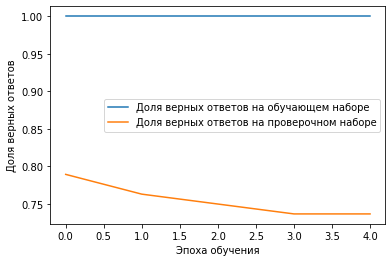

In [ ]:
plt.plot(history_lstm.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_lstm.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Оцениваем качество работы сети на тестовом наборе данных

### Сеть LSTM

Загружаем модель с лучшей долей правильных ответов на проверочном наборе данных

In [ ]:
model_lstm.load_weights(model_lstm_save_path)

Оцениваем качество работы сети на наборе данных для тестирования

In [ ]:
scores = model_lstm.evaluate(x_test, y_test, verbose=1)

2/2 [==============================] - 0s 17ms/step - loss: 1.0251 - accuracy: 0.7368


In [ ]:
print("Доля верных ответов на тестовых данных, в процентах:", round(scores[1] * 100, 4))

Доля верных ответов на тестовых данных, в процентах: 73.6842


**Оцениваем качество работы сети на новых данных**

In [ ]:
text = ''' President Volodymyr Zelensky of Ukraine said Monday that government officials would be prohibited from traveling abroad for vacation or any other unofficial purpose, a move intended to show that corruption would not be allowed to undermine the country’s defense.'''

Преобразуем новости в числовое представление

In [ ]:
text1 = preprocess(text, stop_words, punctuation_marks, morph)

In [ ]:
text1

['president',
 'volodymyr',
 'zelensky',
 'ukraine',
 'said',
 'monday',
 'government',
 'officials',
 'would',
 'prohibited',
 'traveling',
 'abroad',
 'vacation',
 'unofficial',
 'purpose',
 'move',
 'intended',
 'show',
 'corruption',
 'would',
 'allowed',
 'undermine',
 'country',
 '’',
 'defense']

In [ ]:
sequence = text_to_sequence(text1, word_to_index)

In [ ]:
sequence

[19,
 1541,
 702,
 14,
 5,
 37,
 40,
 47,
 8,
 3033,
 1893,
 1758,
 2644,
 257,
 2585,
 136,
 1389,
 8,
 703,
 23,
 2,
 174]

In [ ]:
print(text)
print(sequence)

 President Volodymyr Zelensky of Ukraine said Monday that government officials would be prohibited from traveling abroad for vacation or any other unofficial purpose, a move intended to show that corruption would not be allowed to undermine the country’s defense.
[19, 1541, 702, 14, 5, 37, 40, 47, 8, 3033, 1893, 1758, 2644, 257, 2585, 136, 1389, 8, 703, 23, 2, 174]


In [ ]:
text2 = pad_sequences(sequence, maxlen=max_news_len)

ValueError: ignored

In [ ]:
text2

NameError: ignored

Загружаем модель в память

In [ ]:
model = load_model('best_model_lstm.h5')

Запускаем распознавание (применяем сеть для определения класса новости)

In [ ]:
prediction = model.predict(text2)

NameError: ignored

Результаты распознавания

In [ ]:
prediction

NameError: ignored

In [ ]:
prediction = np.argmax(prediction)

NameError: ignored

In [ ]:
if prediction < 0.5:
    print('Не имеет международного значения')
else:
    print('Международная новость')

NameError: ignored